## import

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, IsolationForest

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

df = pd.read_csv("../data/airquality_clean.csv", parse_dates=["datetime"])
df = df.set_index("datetime")

gt_cols = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
sensor_cols = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)",
               "PT08.S4(NO2)", "PT08.S5(O3)"]
meteo_cols = ["T", "RH", "AH"]
calendar_cols = ["Hour", "Weekday", "Month"]

df.head()


CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  Hour  Weekday  Month
datetime                                                                                                                                                                        
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0    166.0        1056.0    113.0        1692.0       1268.0  13.6  48.9  0.7578    18        2      3
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0    103.0        1174.0     92.0        1559.0        972.0  13.3  47.7  0.7255    19        2      3
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0    131.0        1140.0    114.0        1555.0       1074.0  11.9  54.0  0.7502    20        2      3
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0    172.0        1092.0    122.0        1584.0       1203.0  11.0  60.0  0.7867    21        2      3
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0    131.0        1205.0    116.0        1490.0       1110.0  11.2  59.6  0.7888    22        2      3

## MAD-Based Anomaly Detection

In [78]:
THRESH = 5.0
for col in gt_cols + sensor_cols:

    x = df[col].dropna()
    med = x.median()
    mad = np.median(np.abs(x - med))

    if mad == 0 or np.isnan(mad):
        df[f"anomMAD_{col}"] = False
        continue

    modified_z = 0.6745 * (df[col] - med) / mad
    df[f"anomMAD_{col}"] = np.abs(modified_z) > THRESH

print("Number of MAD anomalies:")
for col in gt_cols + sensor_cols:
    n = int(df[f"anomMAD_{col}"].sum())
    total = df[col].notna().sum()
    print(f"{col:15s}: {n:4d} ({n/total*100:5.2f}%)")


Number of MAD anomalies:
CO(GT)         :   20 ( 0.25%)
NMHC(GT)       :    9 ( 0.96%)
C6H6(GT)       :   28 ( 0.31%)
NOx(GT)        :  122 ( 1.49%)
NO2(GT)        :    0 ( 0.00%)
PT08.S1(CO)    :    0 ( 0.00%)
PT08.S2(NMHC)  :    0 ( 0.00%)
PT08.S3(NOx)   :   21 ( 0.23%)
PT08.S4(NO2)   :    0 ( 0.00%)
PT08.S5(O3)    :    0 ( 0.00%)


## Residual-Based Anomaly Detection

In [79]:
def residual_anomaly(df, target_col, feature_cols, contamination=0.02, random_state=42):
    mask = df[target_col].notna()
    X = df.loc[mask, feature_cols].copy()
    y = df.loc[mask, target_col].values

    X = X.ffill().bfill()

    rf = RandomForestRegressor(
        n_estimators=200,
        min_samples_leaf=5,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X, y)
    y_pred = rf.predict(X)
    resid = np.abs(y - y_pred)

    N = len(resid)
    k = max(int(N * contamination), 3)
    cutoff = np.sort(resid)[-k]
    flags = resid >= cutoff

    full_resid = pd.Series(np.nan, index=df.index)
    full_resid.loc[X.index] = resid

    full_flag = pd.Series(False, index=df.index)
    full_flag.loc[X.index] = flags

    return full_resid, full_flag


In [80]:
gt_feature_cols = sensor_cols + meteo_cols

for col in gt_cols:
    if col == "NMHC(GT)":
        df[f"resid_{col}"] = np.nan
        df[f"anomRES_{col}"] = False
        print("NMHC(GT) has too many missing values, skipping residual-based anomaly detection")
    else:
        resid, flags = residual_anomaly(df, col, gt_feature_cols, contamination=0.01)
        df[f"resid_{col}"] = resid
        df[f"anomRES_{col}"] = flags
        print(f"{col}: Number of residual anomalies = {int(flags.sum())}")


CO(GT): Number of residual anomalies = 80
NMHC(GT) has too many missing values, skipping residual-based anomaly detection
C6H6(GT): Number of residual anomalies = 90
NOx(GT): Number of residual anomalies = 81
NO2(GT): Number of residual anomalies = 81


In [81]:
sensor_feature_base = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"] + sensor_cols + meteo_cols

for s in sensor_cols:
    feature_cols_s = [c for c in sensor_feature_base if c != s]
    resid, flags = residual_anomaly(df, s, feature_cols_s, contamination=0.01)
    df[f"resid_{s}"] = resid
    df[f"anomRES_{s}"] = flags
    print(f"{s}: Number of sensor residual anomalies = {int(flags.sum())}")


PT08.S1(CO): Number of sensor residual anomalies = 90
PT08.S2(NMHC): Number of sensor residual anomalies = 90
PT08.S3(NOx): Number of sensor residual anomalies = 90
PT08.S4(NO2): Number of sensor residual anomalies = 90
PT08.S5(O3): Number of sensor residual anomalies = 90


## Unsupervised method: Isolation Forest Anomaly Detection

In [82]:
if_features = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"] \
              + sensor_cols + meteo_cols + calendar_cols

mask_if = df[if_features].notna().all(axis=1)
X_if = df.loc[mask_if, if_features]

iso = IsolationForest(
    contamination=0.01,
    random_state=42
)
iso.fit(X_if)

df["anomIF"] = False
df.loc[mask_if, "anomIF"] = (iso.predict(X_if) == -1)

df["IF_score"] = np.nan
df.loc[mask_if, "IF_score"] = iso.decision_function(X_if)

print("Global number of Isolation Forest anomalies:", int(df["anomIF"].sum()))


Global number of Isolation Forest anomalies: 77


## Combine Anomaly Signals (MAD, Residual, IF)

In [83]:
for col in gt_cols:
    # if col == "NMHC(GT)":
    #     df[f"anomGT_{col}"] = False
    #     continue
    df[f"anomGT_{col}"] = (
        df[f"anomMAD_{col}"] |
        df[f"anomRES_{col}"] |
        (df["anomIF"] & df[col].notna())
    )

for col in sensor_cols:
    df[f"anomPT08_{col}"] = (
        df[f"anomMAD_{col}"] |
        df[f"anomRES_{col}"] |
        (df["anomIF"] & df[col].notna())
    )

print("Final number of GT anomalies:")
for col in gt_cols:
    n = int(df[f"anomGT_{col}"].sum())
    total = df[col].notna().sum()
    print(f"{col:15s}: {n:4d} ({n/total*100:5.2f}%)")

print("\nFinal number of PT08 anomalies:")
for col in sensor_cols:
    n = int(df[f"anomPT08_{col}"].sum())
    total = df[col].notna().sum()
    print(f"{col:15s}: {n:4d} ({n/total*100:5.2f}%)")


Final number of GT anomalies:
CO(GT)         :  153 ( 1.91%)
NMHC(GT)       :   11 ( 1.17%)
C6H6(GT)       :  144 ( 1.59%)
NOx(GT)        :  202 ( 2.47%)
NO2(GT)        :  156 ( 1.91%)

Final number of PT08 anomalies:
PT08.S1(CO)    :  164 ( 1.81%)
PT08.S2(NMHC)  :  145 ( 1.60%)
PT08.S3(NOx)   :  168 ( 1.85%)
PT08.S4(NO2)   :  161 ( 1.78%)
PT08.S5(O3)    :  165 ( 1.82%)


## Visualize Time-Series Anomalies

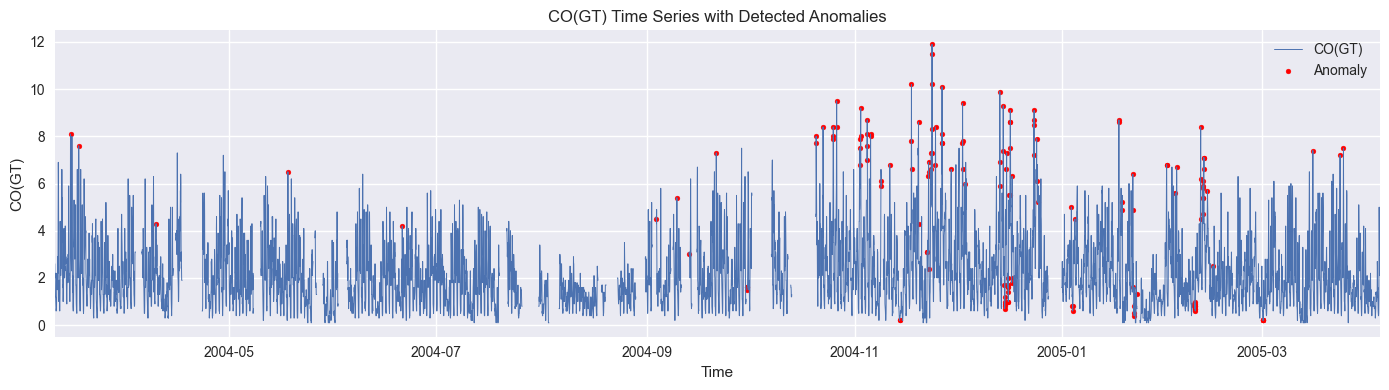

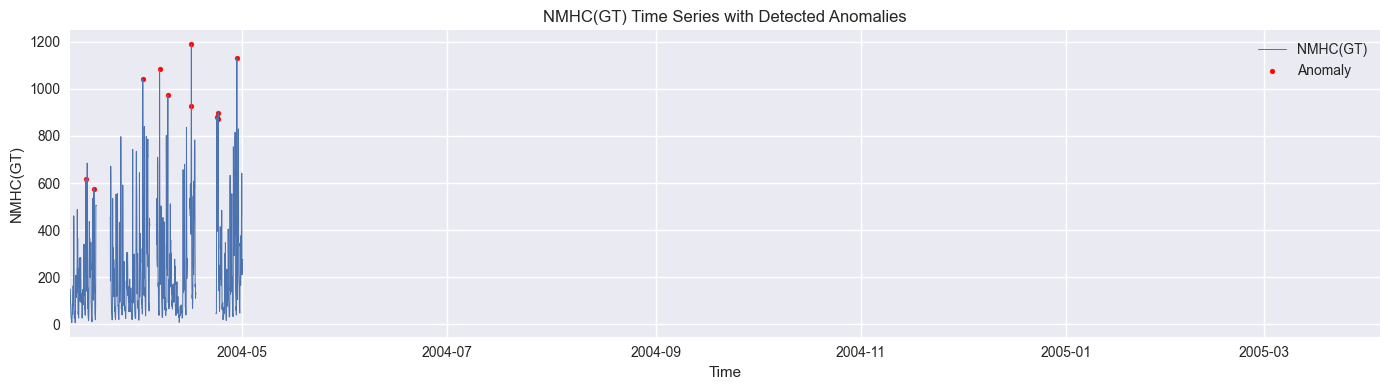

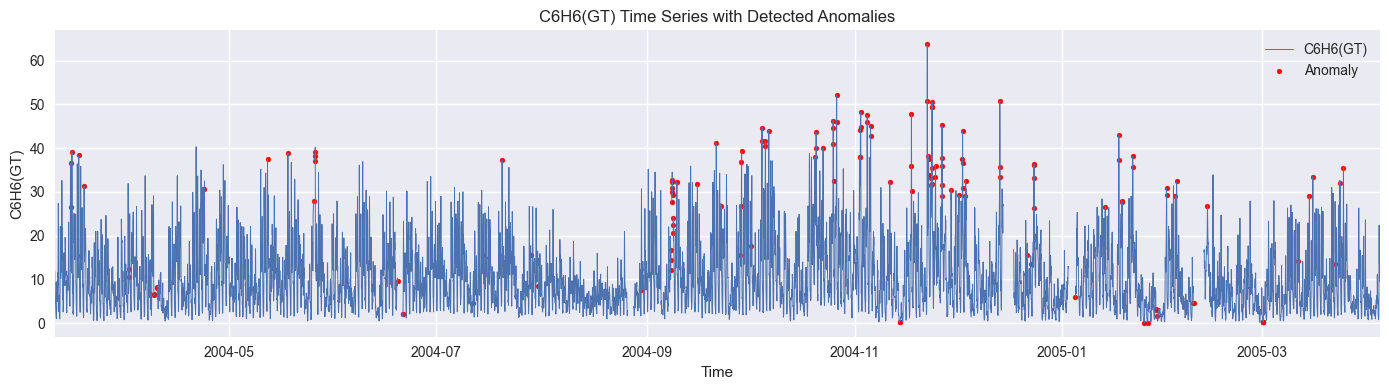

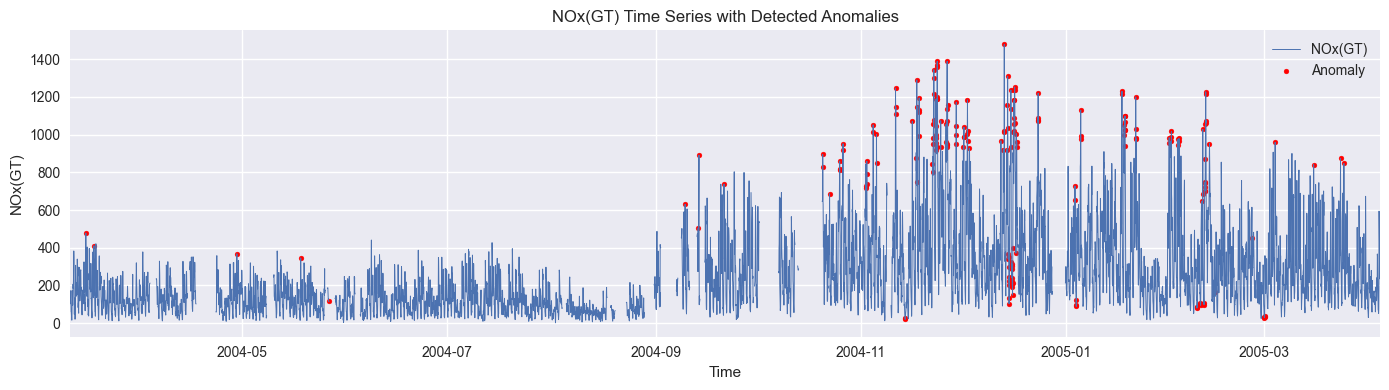

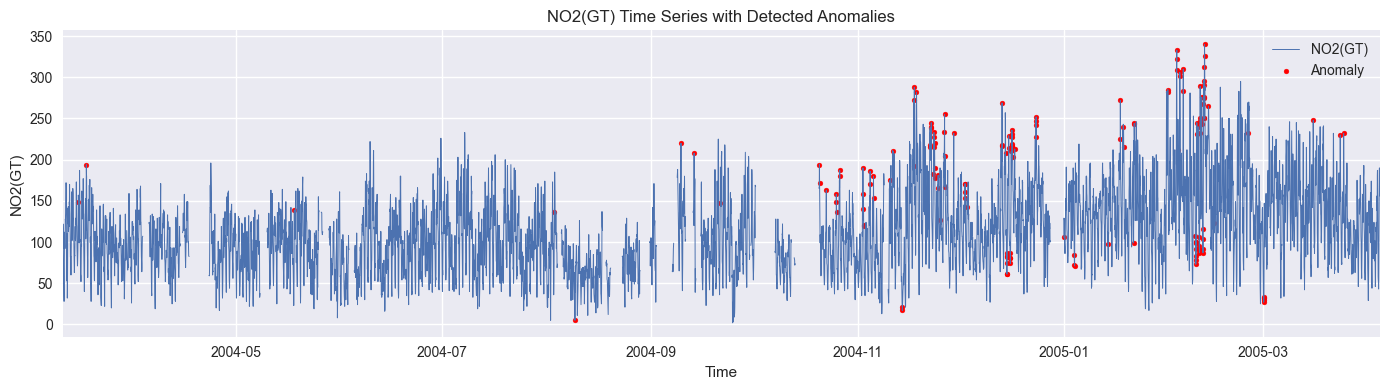

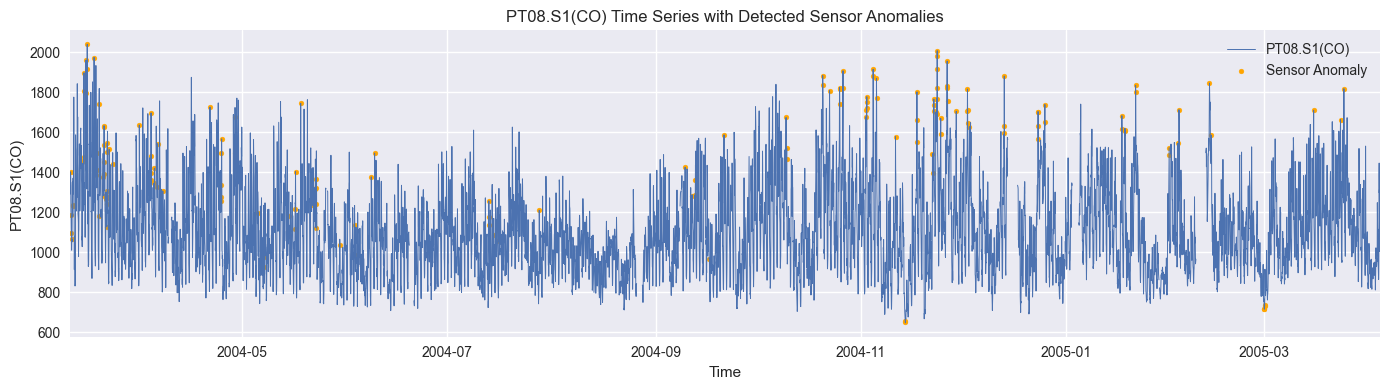

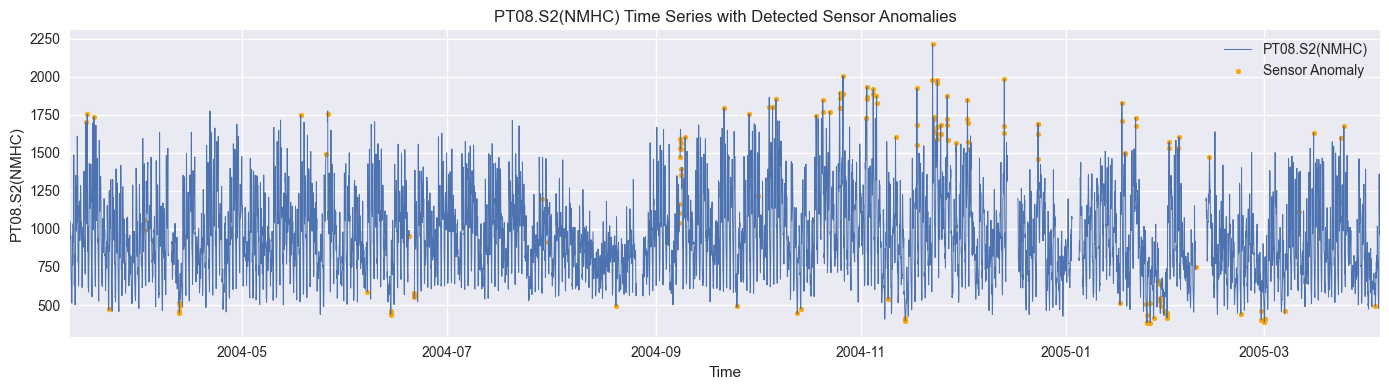

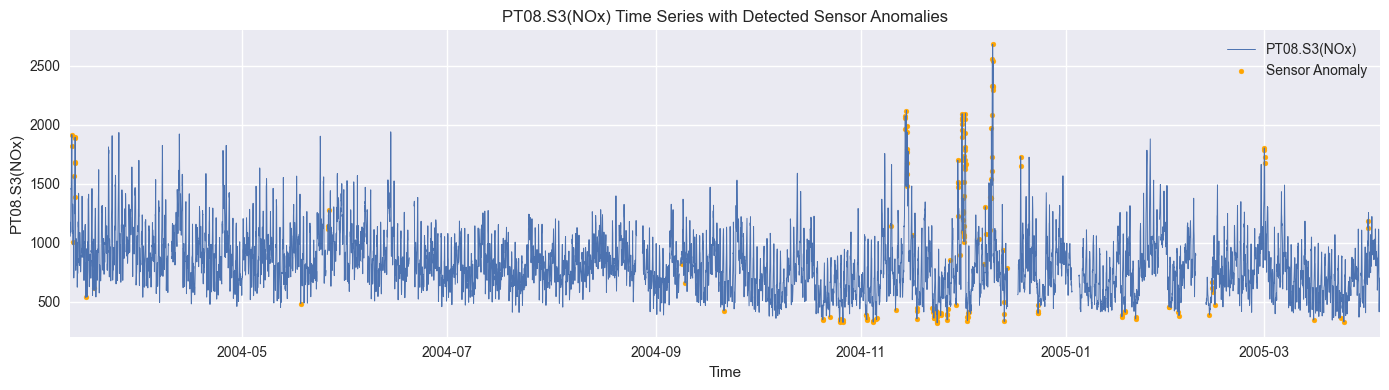

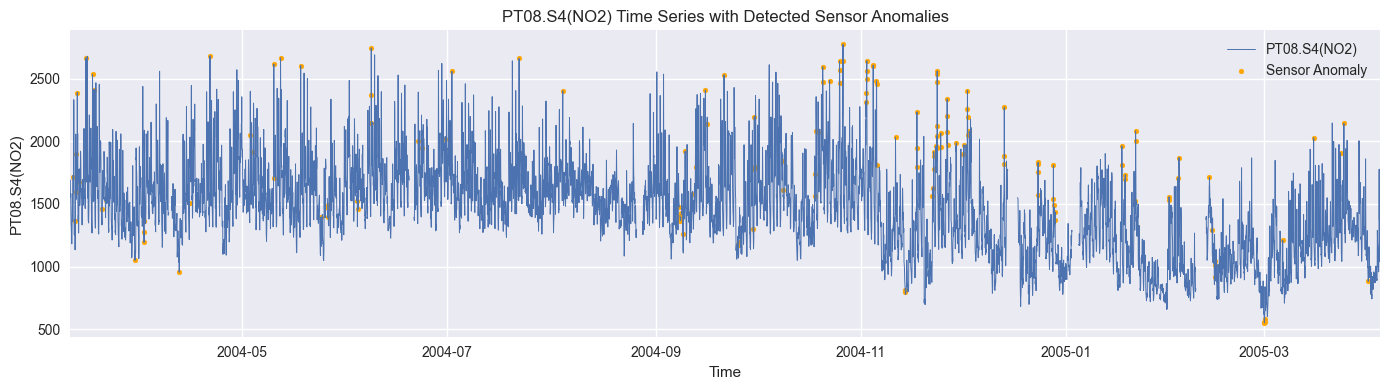

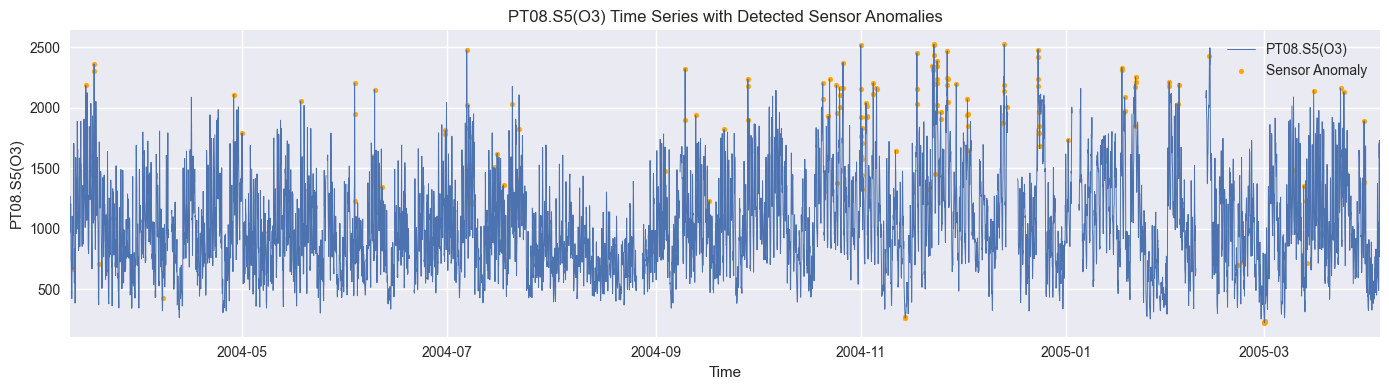

In [84]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


gt_list = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
sensor_list = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)"]

xmin = df.index.min()
xmax = df.index.max()

for target in gt_list:
    flag_col = f"anomGT_{target}"
    if flag_col not in df.columns:
        print(f"[Skip] Missing anomaly flag for {target}")
        continue

    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[target], lw=0.7, label=target)
    plt.scatter(
        df.index[df[flag_col]],
        df.loc[df[flag_col], target],
        s=12, c="red", label="Anomaly"
    )
    plt.title(f"{target} Time Series with Detected Anomalies")
    plt.xlabel("Time")
    plt.ylabel(target)
    plt.xlim(xmin, xmax)
    plt.legend()
    plt.tight_layout()
    plt.show()

for sensor in sensor_list:
    flag_col = f"anomPT08_{sensor}"
    if flag_col not in df.columns:
        print(f"[Skip] Missing anomaly flag for {sensor}")
        continue

    plt.figure(figsize=(14, 4))
    plt.plot(df.index, df[sensor], lw=0.7, label=sensor)
    plt.scatter(
        df.index[df[flag_col]],
        df.loc[df[flag_col], sensor],
        s=12, c="orange", label="Sensor Anomaly"
    )
    plt.title(f"{sensor} Time Series with Detected Sensor Anomalies")
    plt.xlabel("Time")
    plt.ylabel(sensor)
    plt.xlim(xmin, xmax)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Analyze the Relationship among Anomalies, Time, and Weather

In [85]:
df["weekday"] = df.index.weekday
df["hour"] = df.index.hour
df["month"] = df.index.month

gt_list = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

sensor_list = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)",
               "PT08.S4(NO2)", "PT08.S5(O3)"]

records = []

for target in gt_list + sensor_list:
    flag_col = f"anomGT_{target}" if target in gt_list else f"anomPT08_{sensor}"
    dfa = df[df[flag_col]].copy()

    if dfa.empty:
        continue

    records.append({
        "Variable": target,
        "Anomaly_Count": len(dfa),
        "Weekend_Ratio": (dfa["weekday"] >= 5).mean(),
        "Avg_Hour": dfa["hour"].mean(),
        "Temp_Mean": dfa["T"].mean(),
        "Temp_Max": dfa["T"].max(),
        "Temp_Min": dfa["T"].min(),
        "RH_Mean": dfa["RH"].mean()
    })


anomaly_table = pd.DataFrame(records)
display(anomaly_table)

Variable  Anomaly_Count  Weekend_Ratio   Avg_Hour  Temp_Mean  Temp_Max  Temp_Min    RH_Mean
0         CO(GT)            153       0.058824  14.032680  14.113861      35.7      -0.6  56.663366
1       NMHC(GT)             11       0.000000  13.909091  18.109091      24.9      11.9  45.118182
2       C6H6(GT)            144       0.041667  14.923611  16.760417      35.2      -0.6  50.763194
3        NOx(GT)            202       0.024752  13.564356  12.899275      35.2      -0.6  59.018841
4        NO2(GT)            156       0.038462  12.801282  13.401053      35.2      -0.6  57.590526
5    PT08.S1(CO)            165       0.084848  13.872727  17.635152      40.1      -0.6  52.315152
6  PT08.S2(NMHC)            165       0.084848  13.872727  17.635152      40.1      -0.6  52.315152
7   PT08.S3(NOx)            165       0.084848  13.872727  17.635152      40.1      -0.6  52.315152
8   PT08.S4(NO2)            165       0.084848  13.872727  17.635152      40.1      -0.6  52.315152
9    PT08.S5(O3)            165       0.084848  13.872727  17.635152      40.1      -0.6  52.315152

## Anomalies and Temperature Over Time

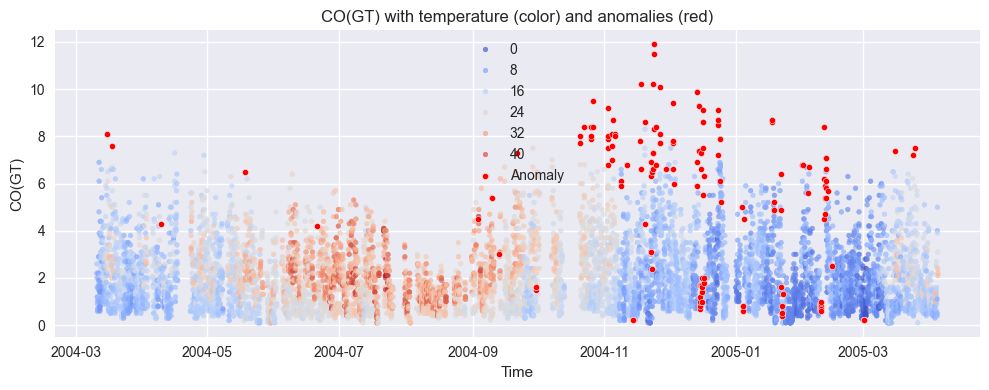

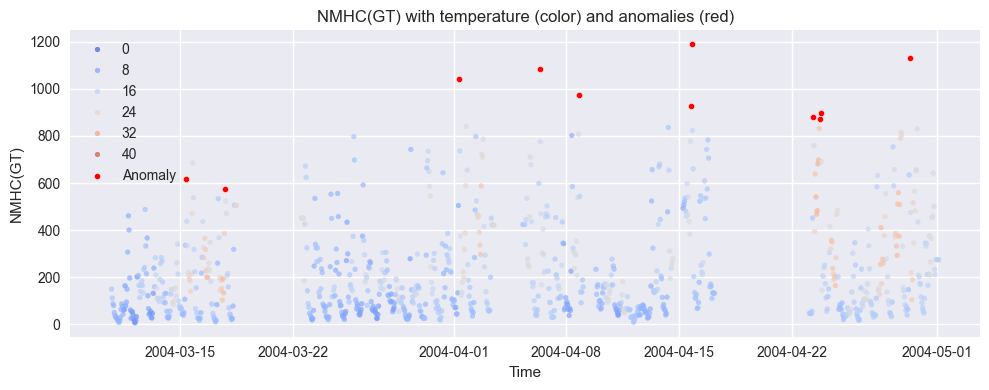

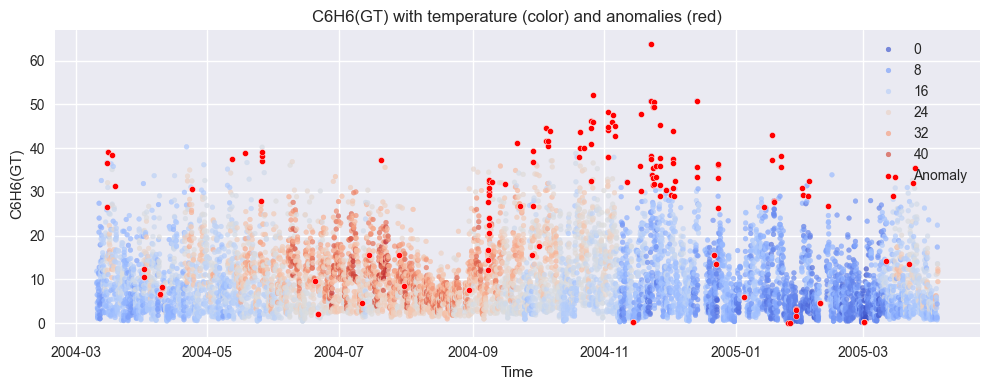

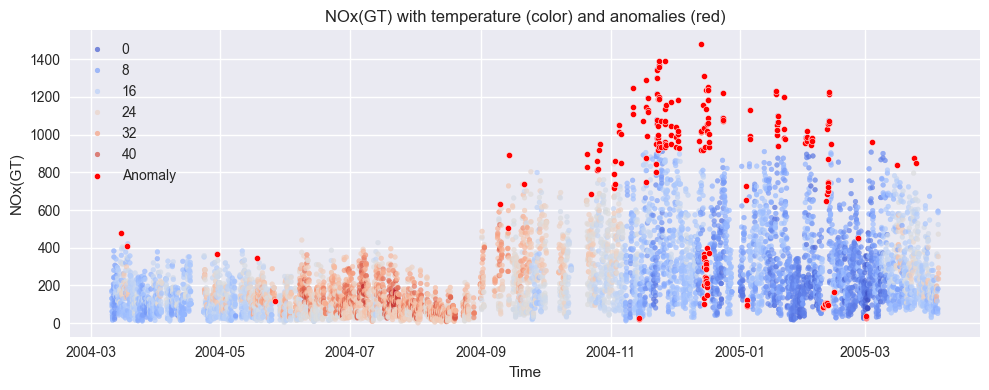

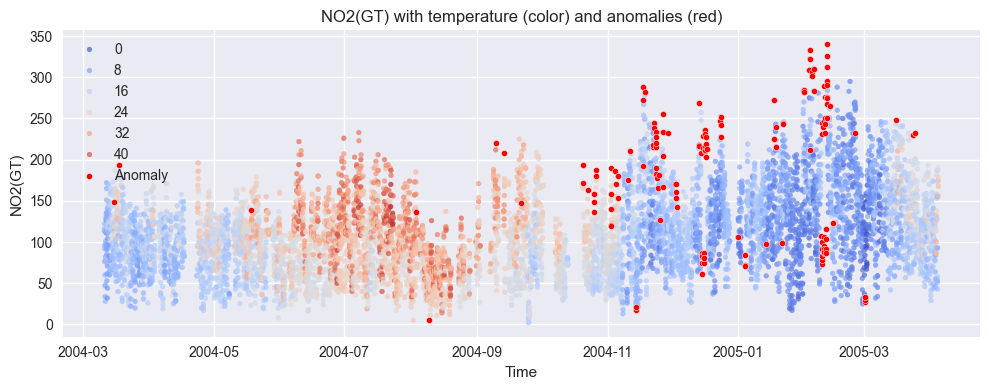

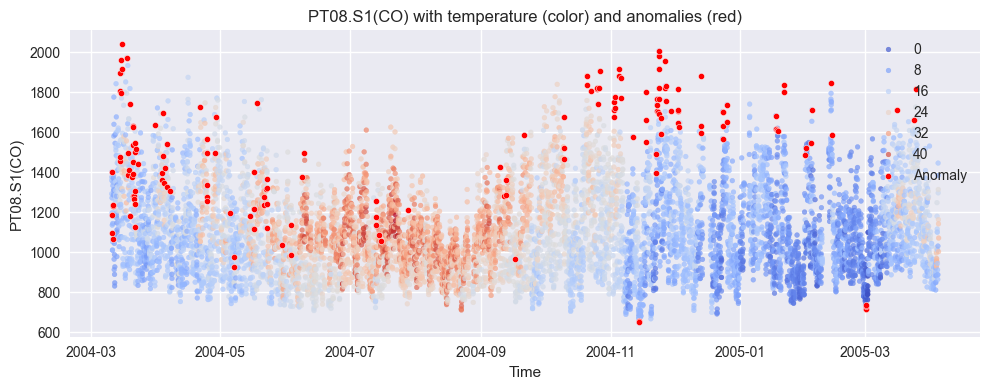

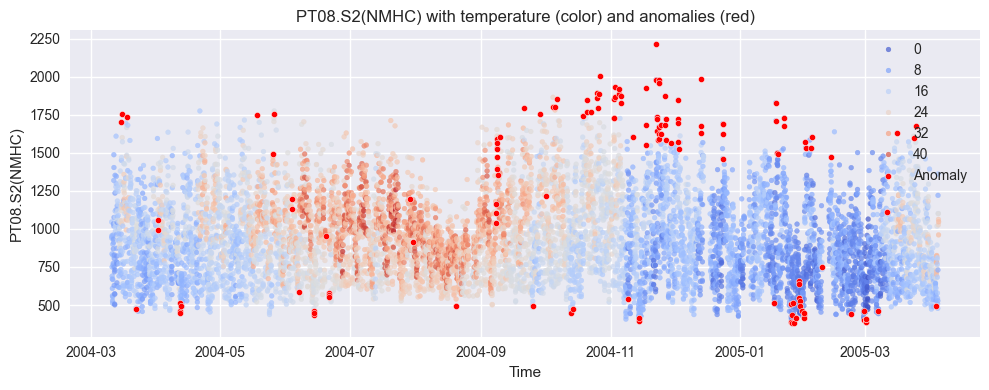

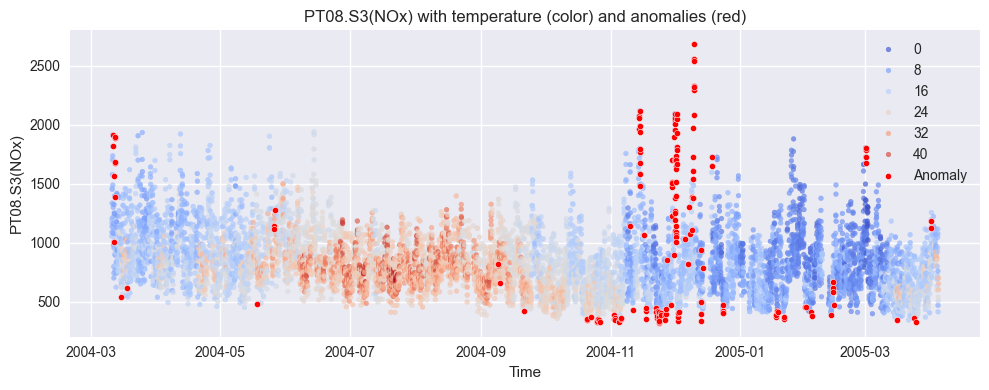

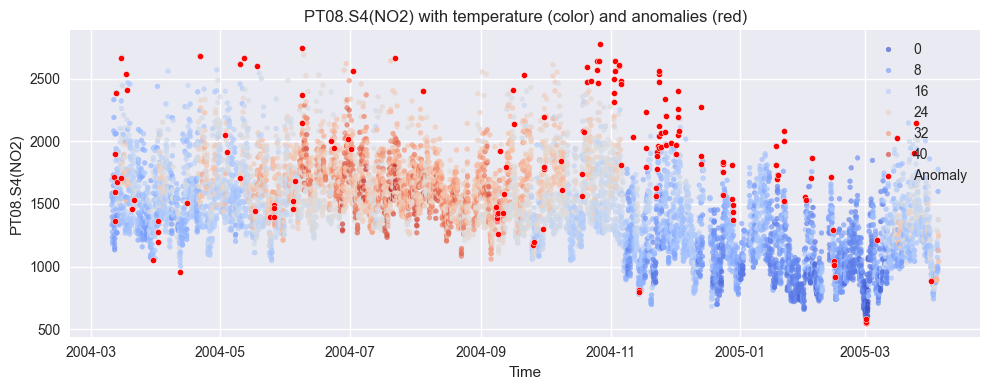

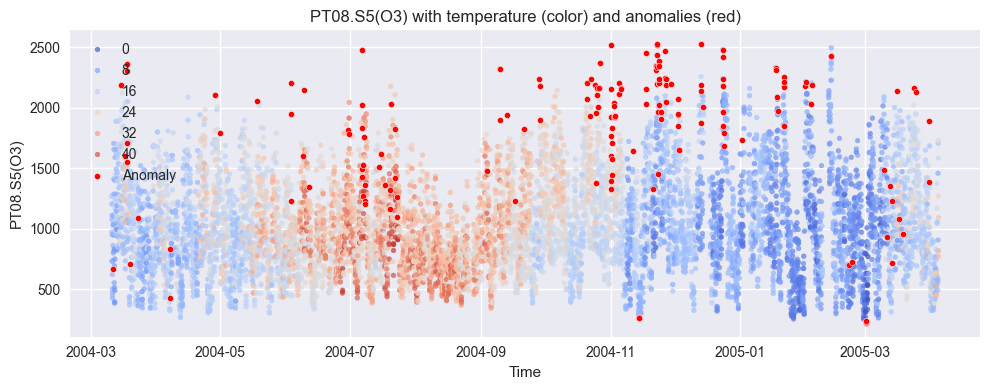

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

for target in gt_list+sensor_list:
    flag = df[f"anomGT_{target}"] if target in gt_list else df[f"anomPT08_{target}"]
    if flag.sum() == 0:
        continue
        
    plt.figure(figsize=(10, 4))
    sns.scatterplot(
        x=df.index, y=df[target], 
        hue=df["T"], palette="coolwarm",
        s=12, edgecolor=None, alpha=0.7
    )
    sns.scatterplot(
        x=df.index[flag],
        y=df.loc[flag, target],
        color="red",
        s=20,
        label="Anomaly"
    )
    plt.title(f"{target} with temperature (color) and anomalies (red)")
    plt.xlabel("Time")
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()


## Weekend Distribution of Anomalies

In [87]:
import numpy as np

for target in gt_list + sensor_list:
    flag = df[f"anomGT_{target}"] if target in gt_list else df[f"anomPT08_{target}"]
    if flag.sum() == 0:
        continue
        
    weekend = df.loc[flag, "weekday"] >= 5
    cnt_weekend = weekend.sum()
    cnt_total = flag.sum()

    print(f"{target}: {cnt_weekend}/{cnt_total} ({cnt_weekend/cnt_total:.1%}) anomalies occurred on weekends")


CO(GT): 9/153 (5.9%) anomalies occurred on weekends
NMHC(GT): 0/11 (0.0%) anomalies occurred on weekends
C6H6(GT): 6/144 (4.2%) anomalies occurred on weekends
NOx(GT): 5/202 (2.5%) anomalies occurred on weekends
NO2(GT): 6/156 (3.8%) anomalies occurred on weekends
PT08.S1(CO): 50/164 (30.5%) anomalies occurred on weekends
PT08.S2(NMHC): 11/145 (7.6%) anomalies occurred on weekends
PT08.S3(NOx): 18/168 (10.7%) anomalies occurred on weekends
PT08.S4(NO2): 15/161 (9.3%) anomalies occurred on weekends
PT08.S5(O3): 14/165 (8.5%) anomalies occurred on weekends


## Visual Comparison: Weekend vs Weekday Anomaly Counts

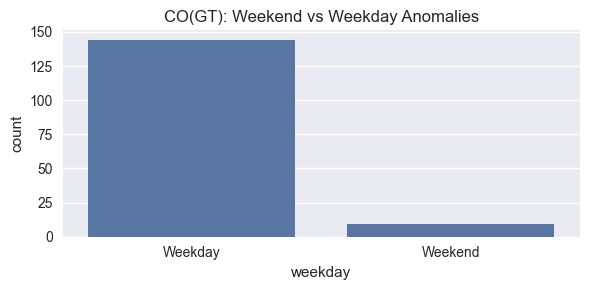

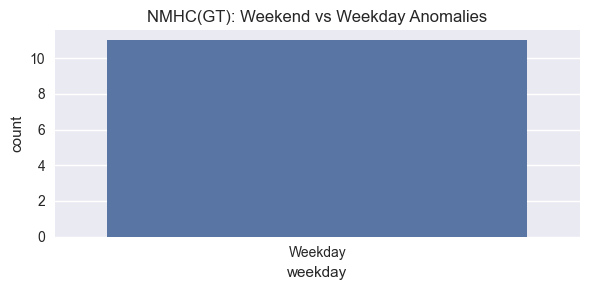

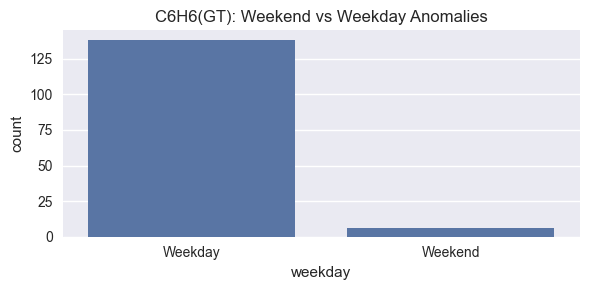

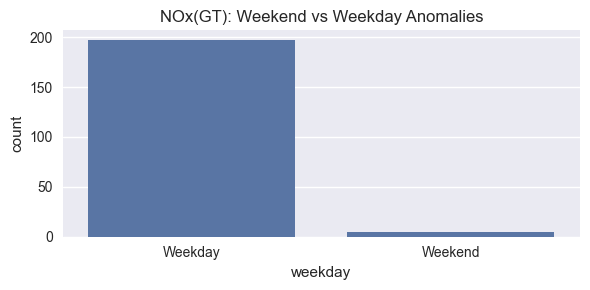

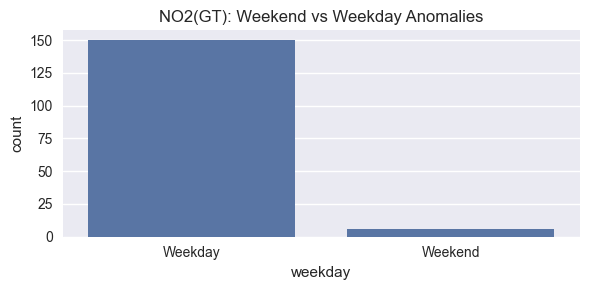

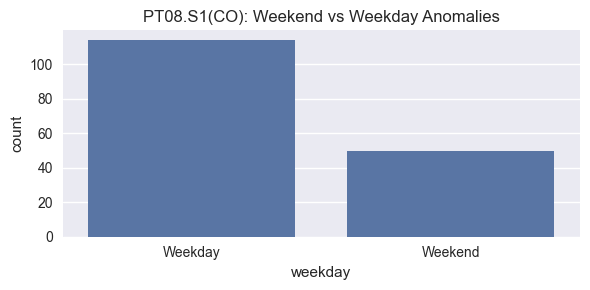

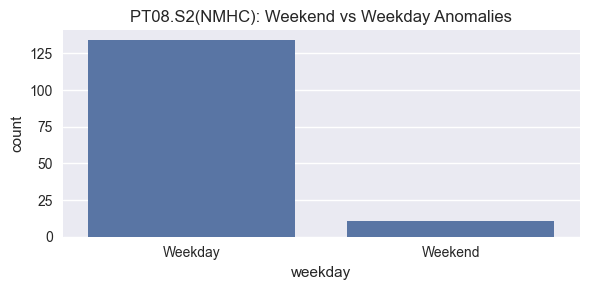

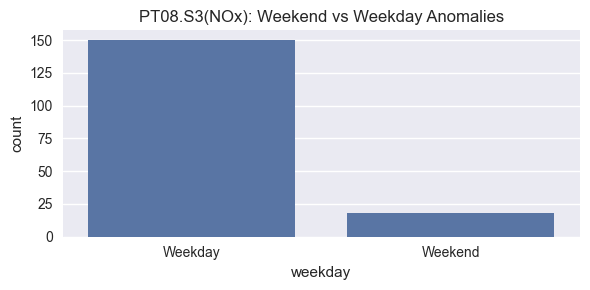

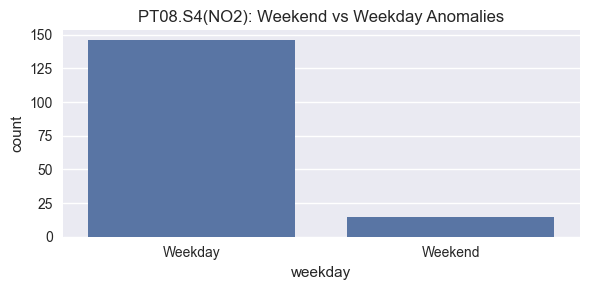

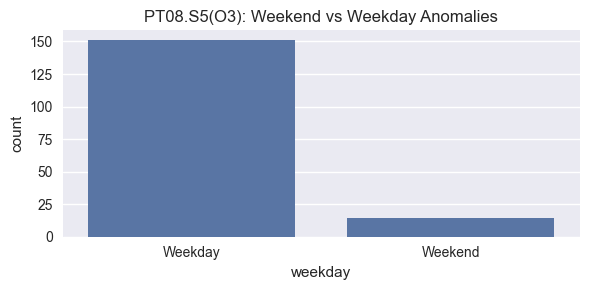

In [88]:
for target in gt_list + sensor_list:
    flag = df[f"anomGT_{target}"] if target in gt_list else df[f"anomPT08_{target}"]
    if flag.sum() == 0:
        continue
        
    dfa = df[flag]
    
    plt.figure(figsize=(6,3))
    sns.countplot(x=(dfa["weekday"]>=5).map({True:"Weekend", False:"Weekday"}))
    plt.title(f"{target}: Weekend vs Weekday Anomalies")
    plt.tight_layout()
    plt.show()


## Hourly Distribution of Anomalies

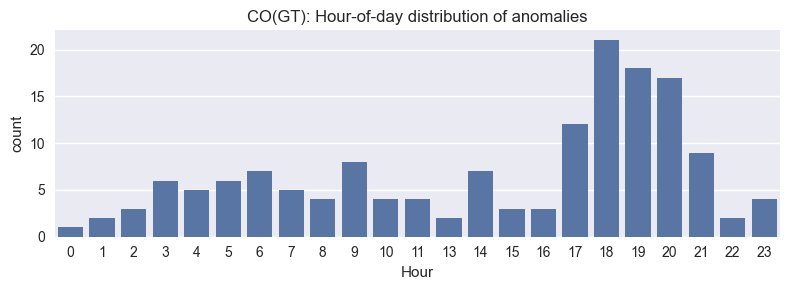

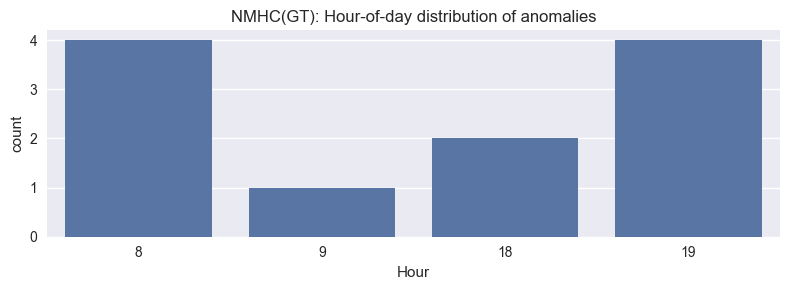

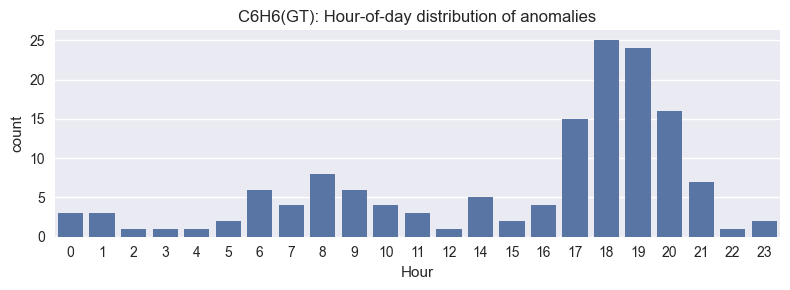

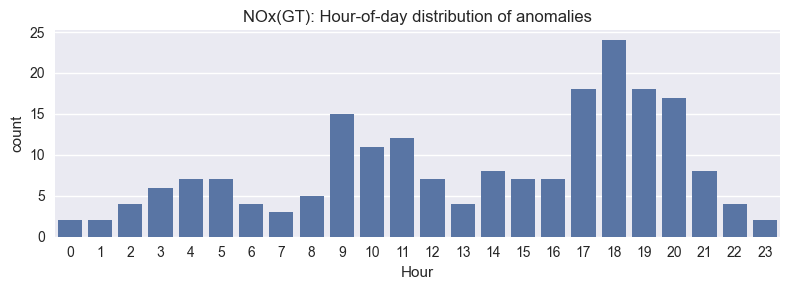

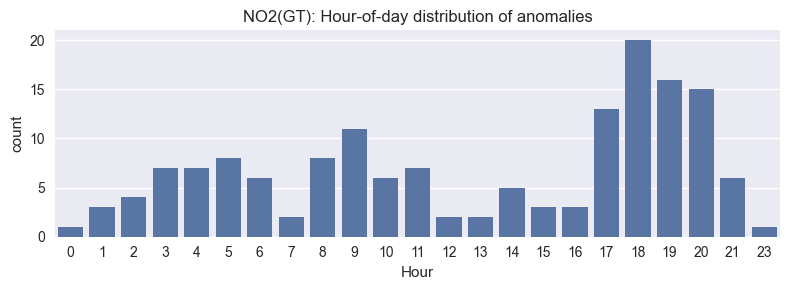

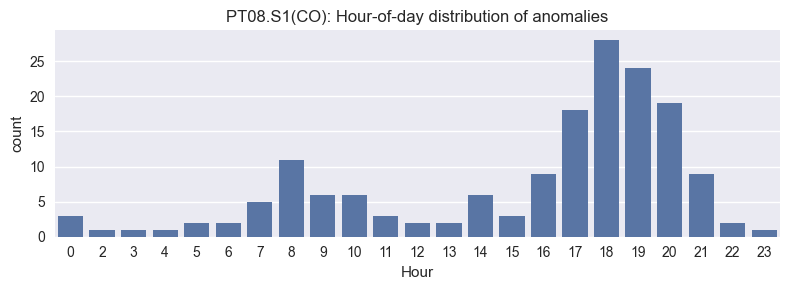

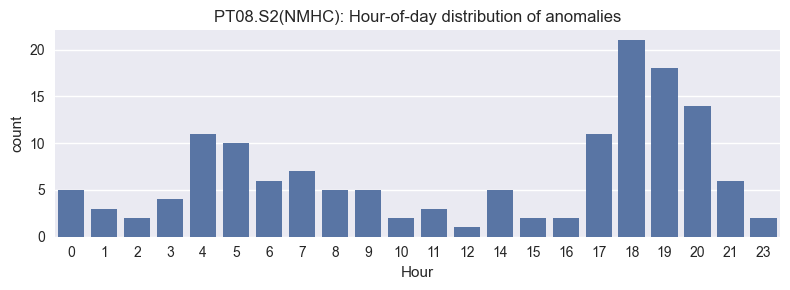

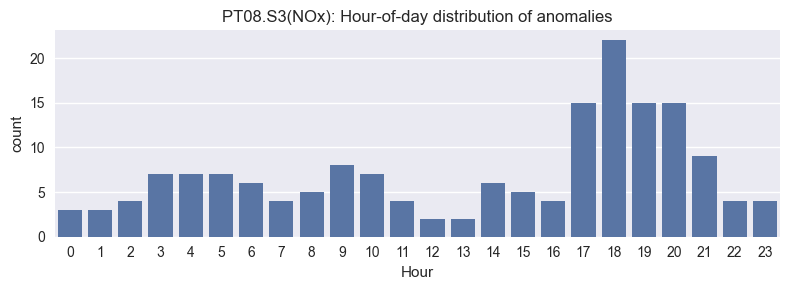

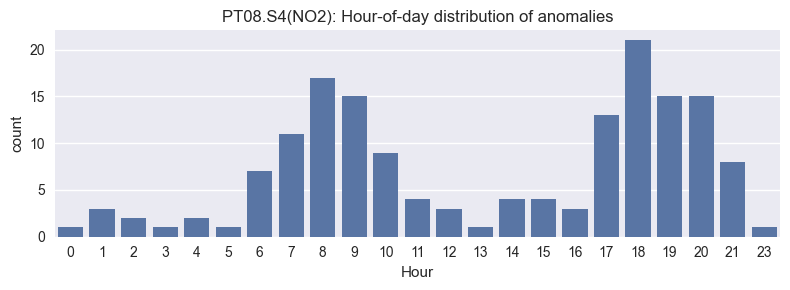

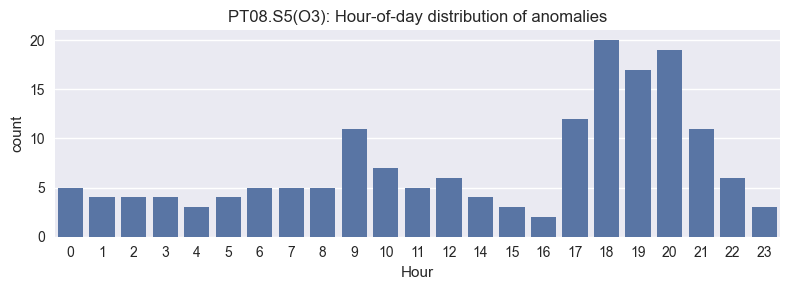

In [89]:
for target in gt_list + sensor_list:
    flag = df[f"anomGT_{target}"] if target in gt_list else df[f"anomPT08_{target}"]
    if flag.sum() == 0:
        continue

    plt.figure(figsize=(8,3))
    sns.countplot(x=df.loc[flag, "hour"])
    plt.title(f"{target}: Hour-of-day distribution of anomalies")
    plt.xlabel("Hour")
    plt.tight_layout()
    plt.show()


## save df to csv

In [90]:
from pathlib import Path

out_dir = Path("../data")
out_dir.mkdir(parents=True, exist_ok=True)

df_all = df.copy()
p1_csv = out_dir / "airquality_clean_with_anomaly.csv"
df_all.to_csv(p1_csv, index=True)

## Robustness Evaluation via Residual and IF-Based Cleaning

In [91]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Features used for predictive modeling (not the anomaly detection features)
feature_cols = sensor_cols + meteo_cols + calendar_cols
feature_cols = [c for c in feature_cols if c in df.columns]

# Contamination levels to try for both residual-based and IF-based anomaly removal
resid_contam_list = [0.005, 0.01, 0.02]   # 0.5%, 1%, 2%
if_contam_list    = [0.005, 0.01, 0.02]

results = []

for target in gt_cols:
    resid_col = f"resid_{target}"
    if resid_col not in df.columns:
        print(f"\n===== {target}: missing {resid_col}, skip =====")
        continue

    if "IF_score" not in df.columns:
        print("\n[Warning] No IF_score column found in df; IF-based modes will be skipped")
        has_if_score = False
    else:
        has_if_score = True

    print(f"\n===== Robustness via precomputed residual + IF for {target} =====")

    # Keep only rows where the target value is present
    df_t = df.dropna(subset=[target]).copy()

    # Time-based split: 2004 = train, 2005 = test
    train_mask = df_t.index.year == 2004
    test_mask  = df_t.index.year == 2005

    train_idx = df_t.index[train_mask]
    test_idx  = df_t.index[test_mask]

    X_train_full = df_t.loc[train_idx, feature_cols]
    y_train_full = df_t.loc[train_idx, target]

    X_test = df_t.loc[test_idx, feature_cols]
    y_test = df_t.loc[test_idx, target]

    if len(X_train_full) < 200 or len(X_test) == 0:
        print("  -> train/test size too small, skip.")
        continue

    # ========== 0) Prepare residual & IF_score ==========
    # Residual on training data (precomputed and already stored in CSV)
    resid_train = df_t.loc[train_idx, resid_col]

    if has_if_score:
        if_score_train = df_t.loc[train_idx, "IF_score"]  # Smaller values = more anomalous

    # ========== 1) Baseline model (no points removed) ==========
    base_model = RandomForestRegressor(
        n_estimators=300,
        random_state=0,
        n_jobs=-1,
        min_samples_leaf=5
    )
    base_model.fit(X_train_full, y_train_full)
    y_pred_base = base_model.predict(X_test)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
    print(f"  Baseline RMSE: {rmse_base:.4f}")

    n_train = len(train_idx)

    # ========== 2) Precompute residual anomaly flags for each rc ==========
    resid_flag_dict = {}
    for rc in resid_contam_list:
        # Top rc residuals are treated as anomalies
        k = max(int(n_train * rc), 1)
        # resid_train may contain NaNs; drop NaNs before sorting
        valid_resid = resid_train.dropna()
        if len(valid_resid) == 0:
            continue
        thresh = np.sort(valid_resid.values)[-k]
        flag = (resid_train >= thresh)
        # NaN residuals are not considered anomalous
        flag = flag.fillna(False)
        resid_flag_dict[rc] = flag

    # ========== 3) Precompute IF anomaly flags for each ic ==========
    if_flag_dict = {}
    if has_if_score:
        for ic in if_contam_list:
            valid_if = if_score_train.dropna()
            if len(valid_if) == 0:
                continue
            # Lower IF_score = more anomalous; select the lowest ic fraction
            score_cut = valid_if.quantile(ic)
            flag_if = (if_score_train <= score_cut)
            flag_if = flag_if.fillna(False)
            if_flag_dict[ic] = flag_if

    # ========== 4) Iterate over different residual / IF contamination and combination modes ==========
    for rc in resid_contam_list:
        if rc not in resid_flag_dict:
            continue
        resid_flag = resid_flag_dict[rc]  # Series(index=train_idx)

        # ---------- Mode 1: residual only ----------
        mode = "resid_only"
        mask_anom = resid_flag.copy()

        n_anom = int(mask_anom.sum())
        if 0 < n_anom <= 0.5 * n_train:
            clean_idx = train_idx[~mask_anom.values]

            if len(clean_idx) >= 100:
                X_train_clean = X_train_full.loc[clean_idx]
                y_train_clean = y_train_full.loc[clean_idx]

                model_clean = RandomForestRegressor(
                    n_estimators=300,
                    random_state=0,
                    n_jobs=-1,
                    min_samples_leaf=5
                )
                model_clean.fit(X_train_clean, y_train_clean)
                y_pred_clean = model_clean.predict(X_test)
                rmse_clean = np.sqrt(mean_squared_error(y_test, y_pred_clean))

                improvement = 100 * (rmse_base - rmse_clean) / rmse_base

                print(
                    f"  rc={rc:.3f}, mode={mode:11s}, "
                    f"removed={n_anom}/{n_train} ({n_anom/n_train:5.2%}), "
                    f"RMSE_clean={rmse_clean:.4f}, improvement={improvement:6.2f}%"
                )

                results.append({
                    "Target": target,
                    "resid_contam": rc,
                    "if_contam": None,
                    "mode": mode,
                    "train_full": n_train,
                    "removed": n_anom,
                    "removed_ratio": n_anom / n_train,
                    "rmse_base": rmse_base,
                    "rmse_clean": rmse_clean,
                    "improvement_%": improvement,
                })

        # ---------- Modes 2/3: IF-related modes ----------
        if not has_if_score:
            continue

        for ic in if_contam_list:
            if ic not in if_flag_dict:
                continue
            if_flag = if_flag_dict[ic]  # Series(index=train_idx)

            # Mode 2: IF only
            mode = "IF_only"
            mask_anom_if = if_flag.copy()
            n_anom_if = int(mask_anom_if.sum())
            if 0 < n_anom_if <= 0.5 * n_train:
                clean_idx = train_idx[~mask_anom_if.values]

                if len(clean_idx) >= 100:
                    X_train_clean = X_train_full.loc[clean_idx]
                    y_train_clean = y_train_full.loc[clean_idx]

                    model_clean = RandomForestRegressor(
                        n_estimators=300,
                        random_state=0,
                        n_jobs=-1,
                        min_samples_leaf=5
                    )
                    model_clean.fit(X_train_clean, y_train_clean)
                    y_pred_clean = model_clean.predict(X_test)
                    rmse_clean = np.sqrt(mean_squared_error(y_test, y_pred_clean))

                    improvement = 100 * (rmse_base - rmse_clean) / rmse_base

                    print(
                        f"  rc={rc:.3f}, ic={ic:.3f}, mode={mode:11s}, "
                        f"removed={n_anom_if}/{n_train} ({n_anom_if/n_train:5.2%}), "
                        f"RMSE_clean={rmse_clean:.4f}, improvement={improvement:6.2f}%"
                    )

                    results.append({
                        "Target": target,
                        "resid_contam": None,
                        "if_contam": ic,
                        "mode": mode,
                        "train_full": n_train,
                        "removed": n_anom_if,
                        "removed_ratio": n_anom_if / n_train,
                        "rmse_base": rmse_base,
                        "rmse_clean": rmse_clean,
                        "improvement_%": improvement,
                    })

            # Mode 3: residual AND IF (intersection, higher precision)
            mode = "resid_AND_IF"
            mask_anom_both = resid_flag & if_flag
            n_anom_both = int(mask_anom_both.sum())
            if 0 < n_anom_both <= 0.5 * n_train:
                clean_idx = train_idx[~mask_anom_both.values]

                if len(clean_idx) >= 100:
                    X_train_clean = X_train_full.loc[clean_idx]
                    y_train_clean = y_train_full.loc[clean_idx]

                    model_clean = RandomForestRegressor(
                        n_estimators=300,
                        random_state=0,
                        n_jobs=-1,
                        min_samples_leaf=5
                    )
                    model_clean.fit(X_train_clean, y_train_clean)
                    y_pred_clean = model_clean.predict(X_test)
                    rmse_clean = np.sqrt(mean_squared_error(y_test, y_pred_clean))

                    improvement = 100 * (rmse_base - rmse_clean) / rmse_base

                    print(
                        f"  rc={rc:.3f}, ic={ic:.3f}, mode={mode:11s}, "
                        f"removed={n_anom_both}/{n_train} ({n_anom_both/n_train:5.2%}), "
                        f"RMSE_clean={rmse_clean:.4f}, improvement={improvement:6.2f}%"
                    )

                    results.append({
                        "Target": target,
                        "resid_contam": rc,
                        "if_contam": ic,
                        "mode": mode,
                        "train_full": n_train,
                        "removed": n_anom_both,
                        "removed_ratio": n_anom_both / n_train,
                        "rmse_base": rmse_base,
                        "rmse_clean": rmse_clean,
                        "improvement_%": improvement,
                    })

# Summary table
robust_df = pd.DataFrame(results)
display(robust_df.style.set_table_attributes('style="display:block; max-height:600px; overflow-y:auto"'))



===== Robustness via precomputed residual + IF for CO(GT) =====


  Baseline RMSE: 0.6335
  rc=0.005, mode=resid_only , removed=30/5803 (0.52%), RMSE_clean=0.6393, improvement= -0.93%
  rc=0.005, ic=0.005, mode=IF_only    , removed=28/5803 (0.48%), RMSE_clean=0.6293, improvement=  0.66%
  rc=0.005, ic=0.005, mode=resid_AND_IF, removed=2/5803 (0.03%), RMSE_clean=0.6324, improvement=  0.17%
  rc=0.005, ic=0.010, mode=IF_only    , removed=56/5803 (0.97%), RMSE_clean=0.6248, improvement=  1.36%
  rc=0.005, ic=0.010, mode=resid_AND_IF, removed=2/5803 (0.03%), RMSE_clean=0.6324, improvement=  0.17%
  rc=0.005, ic=0.020, mode=IF_only    , removed=111/5803 (1.91%), RMSE_clean=0.6205, improvement=  2.05%
  rc=0.005, ic=0.020, mode=resid_AND_IF, removed=3/5803 (0.05%), RMSE_clean=0.6300, improvement=  0.55%
  rc=0.010, mode=resid_only , removed=58/5803 (1.00%), RMSE_clean=0.6405, improvement= -1.11%
  rc=0.010, ic=0.005, mode=IF_only    , removed=28/5803 (0.48%), RMSE_clean=0.6293, improvement=  0.66%
  rc=0.010, ic=0.005, mode=resid_AND_IF, removed=4/5803 (0.

## Robustness of Models to Anomaly Removal

We evaluate how removing different subsets of anomalous samples affects RMSE for each pollutant.  
Anomalies are ranked by (i) residual size and (ii) Isolation Forest (IF) score.  
Below we report the **best two concrete settings** per pollutant.

---

### CO(GT)

- Most settings change RMSE by less than ±2%, and some even make it worse.  
- No configuration produces a clear and stable improvement.

**Conclusion:** Don't remove anomalies for CO(GT); use the full dataset.

---

### C6H6(GT)

Baseline RMSE ≈ **0.0553**

1. **Residual-only, 0.5% top residuals removed**  
   - `mode = resid_only`, `resid_contam = 0.005`  
   - RMSE drops to ≈ **0.0376** → **~32% improvement**

2. **Residual AND IF, 0.5% residual + 2% IF contamination**  
   - `mode = resid_AND_IF`, `resid_contam = 0.005`, `if_contam = 0.020`  
   - RMSE drops to ≈ **0.0313** → **~43% improvement**

**Conclusion:** For C6H6, remove anomalies using a residual + IF rule with  
`resid_contam = 0.005`, `if_contam = 0.020`.

---

### NOx(GT)

Baseline RMSE ≈ **222.22**

1. **Residual-only, 0.5% top residuals removed**  
   - `mode = resid_only`, `resid_contam = 0.005`  
   - RMSE improves by roughly **7–8%**

2. **Residual AND IF, 2% residual + 1% IF contamination**  
   - `mode = resid_AND_IF`, `resid_contam = 0.020`, `if_contam = 0.010`  
   - RMSE improves by roughly **10%**

**Conclusion:** For NOx, cleaning helps. A good default is  
`mode = resid_AND_IF`, `resid_contam = 0.020`, `if_contam = 0.010`.

---

### NO2(GT)

Baseline RMSE ≈ **50.86**

1. **Residual-only, 2% top residuals removed**  
   - `mode = resid_only`, `resid_contam = 0.020`  
   - RMSE improves by about **6%**

2. **Residual AND IF, 0.5% residual + 2% IF contamination**  
   - `mode = resid_AND_IF`, `resid_contam = 0.005`, `if_contam = 0.020`  
   - RMSE improves by about **3–4%**

**Conclusion:** For NO2, anomaly removal gives small but positive gains;  
`resid_contam = 0.020` (residual-only) is a simple and effective choice.
